In [50]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from tabpfn import TabPFNRegressor
from catboost import CatBoostRegressor, Pool
import optuna
from matplotlib import pyplot as plt
from tqdm import tqdm

---
adding simpliest time features

In [25]:
test_df = pd.read_csv('dataset/test.csv')   
train_df = pd.read_csv('dataset/train.csv')
valid_df = pd.read_csv('dataset/validation.csv')

In [26]:
train_df.dtypes

rate               float64
valid_miles        float64
transport_type      object
weight             float64
pickup_date         object
origin_kma          object
destination_kma     object
dtype: object

In [27]:
def add_time_features(df, date_col='pickup_date'):
    '''
    Add simple time features to the dataframe
    '''
    df[date_col] = pd.to_datetime(df[date_col])
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['hour'] = df[date_col].dt.hour
    max_date = pd.to_datetime('2022-10-01')
    df['months_to_max'] = ((max_date.year - df['year']) * 12 + (max_date.month - df['month'])) + 2
    df.drop(date_col, axis=1, inplace=True)  
    return df

In [28]:
train_df = add_time_features(train_df)
valid_df = add_time_features(valid_df)
test_df = add_time_features(test_df)

X_train = train_df.drop('rate', axis=1)
y_train = train_df['rate']
X_valid = valid_df.drop('rate', axis=1)
y_valid = valid_df['rate']
X_test = test_df

In [29]:
X_train_KFEGT = X_train[X_train['transport_type'] == 'KFEGT']
y_train_KFEGT = y_train[X_train['transport_type'] == 'KFEGT']
X_valid_KFEGT = X_valid[X_valid['transport_type'] == 'KFEGT']
y_valid_KFEGT = y_valid[X_valid['transport_type'] == 'KFEGT']

In [30]:
X_train.columns

Index(['valid_miles', 'transport_type', 'weight', 'origin_kma',
       'destination_kma', 'year', 'month', 'day', 'hour', 'months_to_max'],
      dtype='object')

---
trying TabPFN model

In [31]:
reg = TabPFNRegressor()
reg.fit(X_train_KFEGT, y_train_KFEGT)

y_pred = reg.predict(X_valid_KFEGT)

/home/pzla/projects/ml-engineer/.venv/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/pzla/projects/ml-engineer/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pzla/projects/ml-engineer/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pzla/projects/ml-engineer/.venv/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data

In [32]:
# Estimate the model performance by MAPE metric
mape = np.mean(np.abs((y_valid_KFEGT - y_pred) / y_valid_KFEGT)) * 100
print(f'MAPE: {mape:.2f}%')

MAPE: 17.46%


---
trying Catboost model

In [33]:
X_train_KFEGT.dtypes

valid_miles        float64
transport_type      object
weight             float64
origin_kma          object
destination_kma     object
year                 int32
month                int32
day                  int32
hour                 int32
months_to_max        int32
dtype: object

In [34]:
cat_reg = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAPE')
cat_cols = ['transport_type', 'origin_kma', 'destination_kma']
cat_reg.fit(X_train, y_train, cat_features=cat_cols)
y_pred_cat = cat_reg.predict(X_valid_KFEGT)

0:	learn: 0.2967131	total: 39ms	remaining: 39s
1:	learn: 0.2851200	total: 72.8ms	remaining: 36.3s
2:	learn: 0.2744419	total: 112ms	remaining: 37.3s
3:	learn: 0.2647771	total: 144ms	remaining: 35.9s
4:	learn: 0.2565643	total: 177ms	remaining: 35.3s
5:	learn: 0.2489506	total: 210ms	remaining: 34.7s
6:	learn: 0.2414988	total: 232ms	remaining: 33s
7:	learn: 0.2349298	total: 266ms	remaining: 33s
8:	learn: 0.2295803	total: 299ms	remaining: 32.9s
9:	learn: 0.2238793	total: 335ms	remaining: 33.2s
10:	learn: 0.2187385	total: 371ms	remaining: 33.4s
11:	learn: 0.2144453	total: 409ms	remaining: 33.7s
12:	learn: 0.2102178	total: 441ms	remaining: 33.5s
13:	learn: 0.2041774	total: 470ms	remaining: 33.1s
14:	learn: 0.2005647	total: 500ms	remaining: 32.8s
15:	learn: 0.1965254	total: 531ms	remaining: 32.6s
16:	learn: 0.1919397	total: 563ms	remaining: 32.6s
17:	learn: 0.1876424	total: 597ms	remaining: 32.6s
18:	learn: 0.1840368	total: 635ms	remaining: 32.8s
19:	learn: 0.1808082	total: 669ms	remaining: 32

In [35]:
mape = np.mean(np.abs((y_valid_KFEGT - y_pred_cat) / y_valid_KFEGT)) * 100
print(f'MAPE: {mape:.2f}%')

MAPE: 25.62%


---
Optuna hyperparams optimisation for Catboost

In [36]:
# Define categorical features
cat_cols = ['transport_type', 'origin_kma', 'destination_kma']

# Time-series split
tscv = TimeSeriesSplit(n_splits=5)

# Objective function for Optuna hyperparameter tuning
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 500, 3000, step=500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "random_strength": trial.suggest_float("random_strength", 1, 10),
        "loss_function": "MAPE",
        "early_stopping_rounds": 100,
        "eval_metric": "MAPE",
        "verbose": False
    }

    mape_scores = []

    for train_idx, valid_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        train_pool = Pool(X_tr, y_tr, cat_features=cat_cols)
        valid_pool = Pool(X_val, y_val, cat_features=cat_cols)

        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=100, verbose=False)
        
        y_pred = model.predict(X_val)
        mape = mean_absolute_percentage_error(y_val, y_pred)
        mape_scores.append(mape)

    return np.mean(mape_scores)

In [37]:
# Run Optuna for hyperparameter tuning
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Best parameters
best_params = study.best_params
best_params["loss_function"] = "MAPE"
best_params["eval_metric"] = "MAPE"
best_params["early_stopping_rounds"] = 100

[I 2025-02-09 20:40:20,848] A new study created in memory with name: no-name-d3f0ca50-abb5-488b-aa1c-22015cd7268a
[I 2025-02-09 20:42:59,681] Trial 0 finished with value: 0.13060008340698062 and parameters: {'iterations': 2500, 'learning_rate': 0.04499904039557821, 'depth': 6, 'l2_leaf_reg': 8.79503452019992, 'random_strength': 4.7826200456185}. Best is trial 0 with value: 0.13060008340698062.
[I 2025-02-09 20:44:24,278] Trial 1 finished with value: 0.1390534581339647 and parameters: {'iterations': 1500, 'learning_rate': 0.03458190967222964, 'depth': 4, 'l2_leaf_reg': 4.934292848515358, 'random_strength': 1.8673807375554916}. Best is trial 0 with value: 0.13060008340698062.
[I 2025-02-09 20:47:28,307] Trial 2 finished with value: 0.12626826881910005 and parameters: {'iterations': 2500, 'learning_rate': 0.061824808908317305, 'depth': 10, 'l2_leaf_reg': 6.111025595991382, 'random_strength': 7.1230012835574765}. Best is trial 2 with value: 0.12626826881910005.
[I 2025-02-09 20:50:01,866] 

In [42]:
best_params

{'iterations': 2500,
 'learning_rate': 0.061824808908317305,
 'depth': 10,
 'l2_leaf_reg': 6.111025595991382,
 'random_strength': 7.1230012835574765,
 'loss_function': 'MAPE',
 'eval_metric': 'MAPE',
 'early_stopping_rounds': 100}

In [38]:
# Train final model with best params
final_model = CatBoostRegressor(**best_params)
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [39]:
final_model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=100, verbose=100)

# Predict on validation set
y_pred_cat = final_model.predict(X_valid)

# Evaluate performance
mape_score = mean_absolute_percentage_error(y_valid, y_pred_cat)
print(f"Final Validation MAPE: {mape_score:.2f}")

0:	learn: 0.3012933	test: 0.3207198	best: 0.3207198 (0)	total: 53.6ms	remaining: 2m 13s
100:	learn: 0.1225276	test: 0.1594711	best: 0.1594711 (100)	total: 4.42s	remaining: 1m 45s
200:	learn: 0.1112077	test: 0.1458918	best: 0.1458918 (200)	total: 8.22s	remaining: 1m 34s
300:	learn: 0.0980763	test: 0.1313225	best: 0.1313225 (300)	total: 12.7s	remaining: 1m 33s
400:	learn: 0.0912872	test: 0.1258547	best: 0.1258447 (399)	total: 17.3s	remaining: 1m 30s
500:	learn: 0.0870849	test: 0.1205360	best: 0.1205360 (500)	total: 21.9s	remaining: 1m 27s
600:	learn: 0.0840501	test: 0.1182322	best: 0.1182250 (599)	total: 26.5s	remaining: 1m 23s
700:	learn: 0.0818773	test: 0.1162290	best: 0.1162290 (700)	total: 31.1s	remaining: 1m 19s
800:	learn: 0.0800894	test: 0.1144691	best: 0.1144653 (799)	total: 35.8s	remaining: 1m 15s
900:	learn: 0.0785575	test: 0.1129342	best: 0.1129342 (900)	total: 40.4s	remaining: 1m 11s
1000:	learn: 0.0771138	test: 0.1112618	best: 0.1112617 (996)	total: 45.1s	remaining: 1m 7s
11

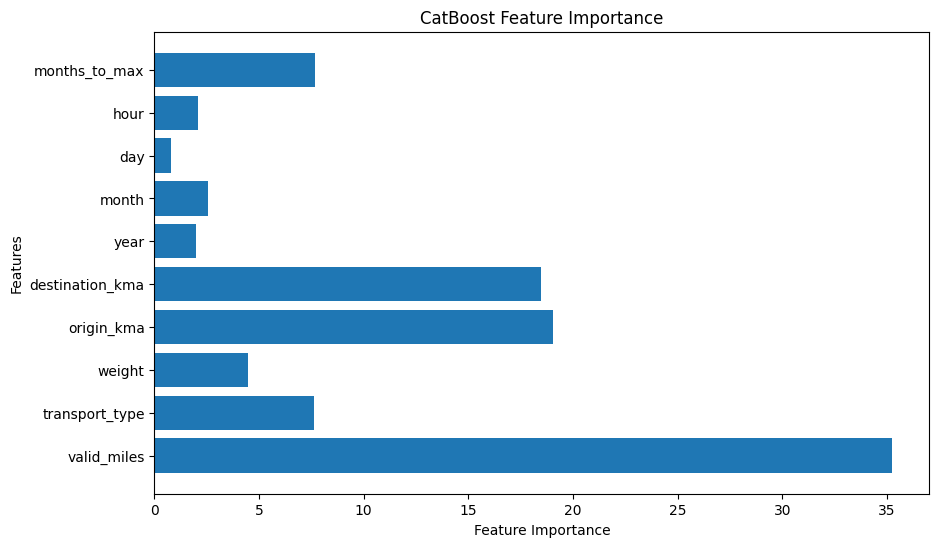

In [41]:
# Feature Importance
feature_importance = final_model.get_feature_importance()
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.show()

---
try take only 2021 and 2022 for training

In [43]:
# train dataframe whith 2021 and 2022 data
train_df_2021 = train_df[train_df['year'] >= 2021]
X_train_2021 = train_df_2021.drop('rate', axis=1)
y_train_2021 = train_df_2021['rate']

In [44]:
model2021 = CatBoostRegressor(**best_params)
train_pool = Pool(X_train_2021, y_train_2021, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)


model2021.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=100, verbose=100)
y_pred_cat = model2021.predict(X_valid)
mape_score = mean_absolute_percentage_error(y_valid, y_pred_cat)
print(f"Final Validation MAPE: {mape_score:.2f}")

0:	learn: 0.2989552	test: 0.3350234	best: 0.3350234 (0)	total: 12.9ms	remaining: 32.1s
100:	learn: 0.1099530	test: 0.1572106	best: 0.1572106 (100)	total: 2.88s	remaining: 1m 8s
200:	learn: 0.0975814	test: 0.1410829	best: 0.1410829 (200)	total: 5.43s	remaining: 1m 2s
300:	learn: 0.0848046	test: 0.1284202	best: 0.1284202 (300)	total: 8.42s	remaining: 1m 1s
400:	learn: 0.0776119	test: 0.1209718	best: 0.1209718 (400)	total: 11.4s	remaining: 59.6s
500:	learn: 0.0733458	test: 0.1155422	best: 0.1155422 (500)	total: 14.4s	remaining: 57.3s
600:	learn: 0.0700501	test: 0.1113061	best: 0.1113061 (600)	total: 17.4s	remaining: 54.9s
700:	learn: 0.0676460	test: 0.1083416	best: 0.1083416 (700)	total: 20.4s	remaining: 52.4s
800:	learn: 0.0656166	test: 0.1065050	best: 0.1065050 (800)	total: 23.4s	remaining: 49.7s
900:	learn: 0.0640099	test: 0.1056524	best: 0.1056516 (899)	total: 26.3s	remaining: 46.7s
1000:	learn: 0.0626486	test: 0.1043814	best: 0.1043814 (1000)	total: 29.3s	remaining: 43.8s
1100:	learn

In [ ]:
#save CatBoost model
model2021.save_model("catboost_model.cbm")

---
TabPFN v2 model for subsets of data

In [45]:
X_train_2021.head()

,valid_miles,transport_type,weight,origin_kma,destination_kma,year,month,day,hour,months_to_max
111113,203.7680,MKPFX,36933.75,SZJLZ,NTODX,2021,1,1,0,23
111114,156.5980,MKPFX,9700.10,FPZNC,NTODX,2021,1,1,0,23
111115,318.7916,MKPFX,33300.00,DRRUD,LMLEC,2021,1,1,0,23
111116,327.0953,MKPFX,19050.00,GVJCT,OKWUS,2021,1,1,0,23
111117,264.9110,MKPFX,40748.00,AQUVM,KPOER,2021,1,1,0,23


In [46]:
y_train_2021.head() 

111113    4.8050
111114    5.4208
111115    4.3391
111116    3.9808
111117    3.9880
Name: rate, dtype: float64

In [47]:
X_train_2021_sorted = X_train_2021.sort_values(['year', 'month', 'day', 'hour']).copy()
y_train_2021_sorted = y_train_2021.loc[X_train_2021_sorted.index]

In [48]:
def get_suitable_train_subset(train_df, origin, destination, max_rows=5000):
    """
    Returns a subset of train_df up to 'max_rows':
    1) All rows with the same (origin, destination).
    2) If < max_rows, fill with the most recent rows from the same origin
       but different destinations, until you reach max_rows.
    """
    # A) All with same (origin, destination)
    same_ori_dst = train_df[
        (train_df['origin_kma'] == origin) &
        (train_df['destination_kma'] == destination)
    ]
    
    if len(same_ori_dst) >= max_rows:
        # If enough rows, just pick the most recent 'max_rows'
        subset = same_ori_dst.tail(max_rows)
    else:
        # Use all same (origin, destination)
        subset = same_ori_dst
        
        # B) Fill up with same origin, other destinations
        remainder = max_rows - len(subset)
        same_origin_other_dst = train_df[
            (train_df['origin_kma'] == origin) &
            (train_df['destination_kma'] != destination)
        ].sort_values(['year', 'month', 'day', 'hour'])  # ensure chronological
        
        additional = same_origin_other_dst.tail(remainder)
        subset = pd.concat([subset, additional])
    
    return subset

In [49]:
grouped_valid = X_valid.groupby(["origin_kma", "destination_kma"])
predictions = pd.Series(index=X_valid.index, dtype=float)


In [53]:
# Loop over each group => single (origin, destination) pair
for (origin, destination), group_df in tqdm(grouped_valid):
    # A) Grab the suitable training subset
    train_subset = get_suitable_train_subset(X_train_2021_sorted, origin, destination, max_rows=5000)
    y_subset = y_train_2021_sorted.loc[train_subset.index]
    
    reg = TabPFNRegressor()
    reg.fit(train_subset, y_subset)
    group_pred = reg.predict(group_df)
    
    # D) Store predictions in 'predictions' for these specific indices
    predictions.loc[group_df.index] = group_pred


mape = mean_absolute_percentage_error(y_valid, predictions)
print("Validation MAPE:", mape)

  0%|          | 0/1151 [00:00<?, ?it/s]/home/pzla/projects/ml-engineer/.venv/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/pzla/projects/ml-engineer/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pzla/projects/ml-engineer/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pzla/projects/ml-engineer/.venv/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use

Validation MAPE: 0.08428388887862973


---
choosing mode blending param

In [60]:
min_mape = 1
best_alpha = 0
for a in range(0, 41):
    alpha = a / 40
    mape_score = mean_absolute_percentage_error(y_valid, (alpha*y_pred_cat + (1-alpha)*predictions))
    if mape_score < min_mape:
        min_mape = mape_score
        best_alpha = alpha

print(f"Final Validation MAPE: {min_mape:.4f} with alpha={best_alpha:.2f}")

Final Validation MAPE: 0.0827 with alpha=0.25
